# Protein Embedding Analysis with Transformers

This notebook explores protein embeddings using transformer models to capture structural and functional properties in high-dimensional space.

## Contents
1. Generate embeddings for all proteins in the dataset
2. Visualize embeddings with PCA dimensionality reduction 
3. Analyze per token embeddings for a sample sequence

## Setup
1. First, check out `pre_processing.ipynb` if you haven't already.

2. To install the required packages, run:
```
pip install -r requirements.txt
```
---

In [5]:
from transformers import AutoTokenizer, AutoModel
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
from tqdm import tqdm
import os

dataset = "../datasets/protein_dataset.tsv"
embeddings_file = "../datasets/sequence_embeddings.csv"
sequences_dataset = "../datasets/raw/sequences_dataset.csv"
checkpoint_file = "../datasets/embedding_checkpoint.csv"

## Embedding analysis

We use `Facebook ESM2` pre-trained model for sequence embedding. It’s designed to understand and represent protein sequences in the same way language models (like GPT) understand natural language. Instead of words, it learns the "language" of amino acids.
This model takes a sequence string for input and outputs a `320 dimensional` embedding vector.

In the following we embedded an example sequence with a length of 65 for better understanding.

Sequence length:  65
Embedding shape: torch.Size([1, 320])


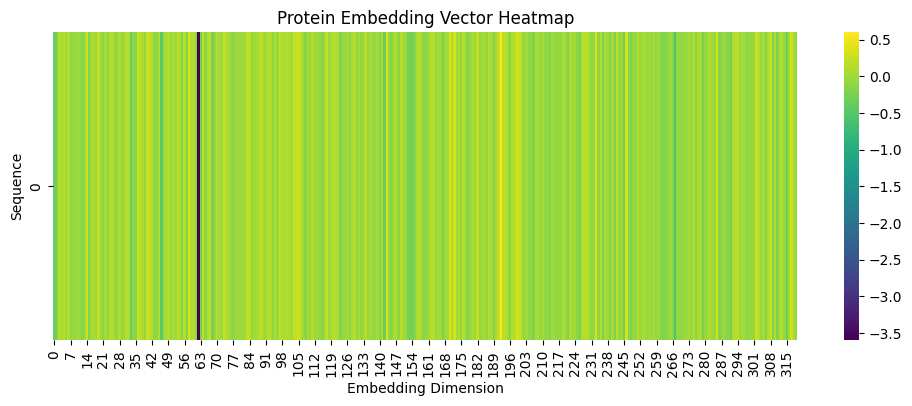

In [7]:
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = AutoModel.from_pretrained("facebook/esm2_t6_8M_UR50D", add_pooling_layer=False)

sequence = "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"
print("Sequence length: ", len(sequence))

inputs = tokenizer(sequence, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)

embeddings = outputs.last_hidden_state.mean(dim=1)

print(f"Embedding shape: {embeddings.shape}")

plt.figure(figsize=(12, 4))
sns.heatmap(embeddings.numpy(), cmap="viridis")
plt.title("Protein Embedding Vector Heatmap")
plt.xlabel("Embedding Dimension")
plt.ylabel("Sequence")
plt.show()

Tokenizing in protein language is fairly easy, Each amino-acid or letter in the sequence represent as a token. You can see per-token embeddings for first 20 dimensions below.

This heatmap shows that the pre-trained model understands the relations between amino-acids duo to their positioning. For example the last two amino-acids of example sequence are both "G", But in the heatmap you can see the last two tokens have dieffrents embeddings, This happens because the model is a transformer and it's picking up long range relationships between amino-acids.

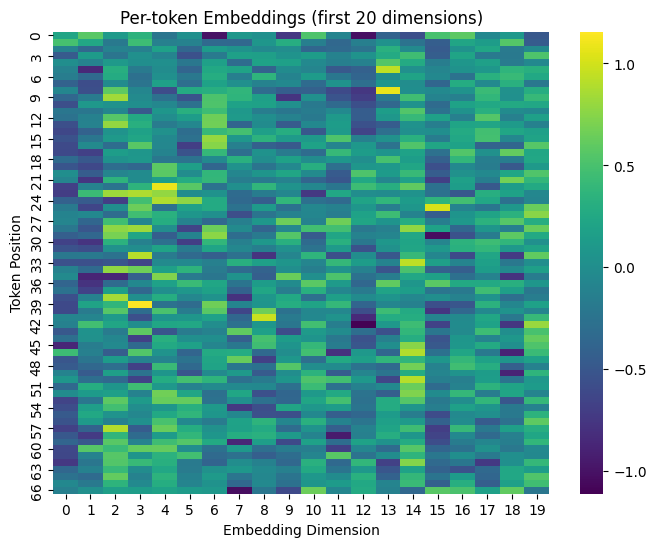

In [10]:
token_embeddings = outputs.last_hidden_state[0]

plt.figure(figsize=(8, 6))
sns.heatmap(token_embeddings.numpy()[:, :20], cmap="viridis")
plt.title("Per-token Embeddings (first 20 dimensions)")
plt.xlabel("Embedding Dimension")
plt.ylabel("Token Position")
plt.show()

We use PCA to visualize high-dimensional token representations in a lower-dimensional space.

**insights:**
- **Clustering:** Some groups of tokens are close to each other, indicating that they have similar representations in the model's embedding space.

- **Separation:** Tokens from different parts of the sequence may occupy different regions, hinting at a possible progression or shift in semantic or syntactic roles.

- **Outliers:** A few tokens are far from the main cloud — possibly unique or semantically distinct tokens.


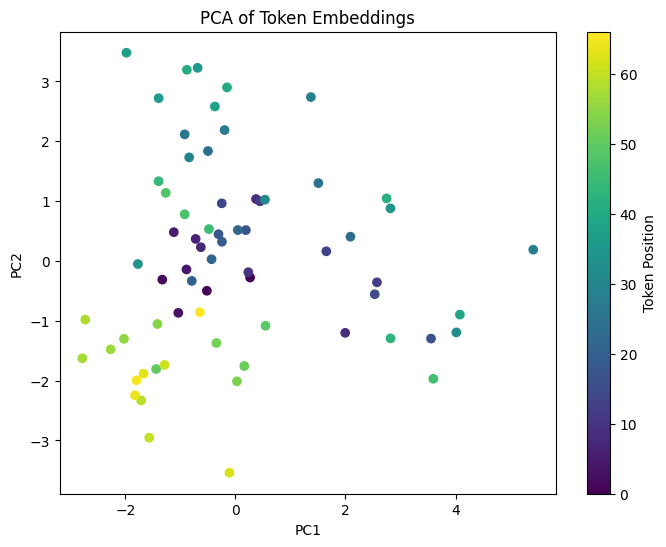

In [11]:
# PCA
pca = PCA(n_components=2)
token_embeddings_2d = pca.fit_transform(token_embeddings.numpy())

plt.figure(figsize=(8, 6))
plt.scatter(
    token_embeddings_2d[:, 0],
    token_embeddings_2d[:, 1],
    c=np.arange(token_embeddings_2d.shape[0]),
    cmap="viridis",
)
plt.colorbar(label="Token Position")
plt.title("PCA of Token Embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [5]:
# Unembedding the sequence
print("\nUnembedding the sequence:")
tokens = tokenizer.convert_ids_to_tokens(inputs.input_ids[0])
amino_acids = [token.replace("<", "").replace(">", "") for token in tokens]
amino_acids = [aa for aa in amino_acids if aa not in ["cls", "pad", "eos", "mask"]]
unembedded_sequence = "".join(amino_acids)
print("Original sequence:", sequence)
print("Unembedded sequence:", unembedded_sequence)
print("Equal:", sequence == unembedded_sequence)


Unembedding the sequence:
Original sequence: MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG
Unembedded sequence: MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG
Equal: True
